## 3. Классификация

При обработке изображения, нужно определить, является ли она *ведущей (первой)* страницей в документе или нет. Это необходимо, если нам на вход подают несколько документов постранично, и мы хотим разделить их на отдельные документы.

Соответственно, нужно определить, является ли изображение *ведущей* **(первой)** страницей документа. В данном задании можно использовать как методы CV, так и NLP на извлеченном тексте.

На вход подается файл-изображение в формате ***.tif**. Адрес API и названия параметров для входных данных придумайте самостоятельно.

### Данные для обучения

Данные для обучения находятся в **pages/pages**. У каждой страницы в имени файла есть информация о её номере в документе – суффикс **_X**, который обозначает, что это **X-ая** страница документа.

Например, *aah97e00-page02_1.tif* и *aah97e00-page02_2.tif*. Как видно, у них в конце есть суффикс с индексом страницы.

Если же префикс вообще отсутствует, как, например, у *aam09c00.tif*, то это означает, что страница единственная в документе.

### Выходные данные

JSON с описанием является ли страница ведущей (первой) или нет. Структура JSON должна быть такой:

``` json
{
 "source": {
  "width": 200,
  "height": 200,
  "type": "main"
 }
} 

```

Информация аналогична той, что и в других заданиях (полное описание есть в задании 1).

К описанию добавилось поле *type*. Укажите значение **main**, если страница ведущая и **other**, если нет.

In [116]:
!pip install reg

In [117]:
import os
import random
import cv2
from tqdm import tqdm
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from PIL import Image
from pathlib import Path
import tensorflow as tf
import random
import re

random.seed(1)

In [118]:
# gpu_device = tf.config.experimental.list_physical_devices('GPU')
# if gpu_device:
#     tf.config.experimental.set_memory_growth(gpu_device[0], True)

In [119]:
DATA_ROOT = '../pages/'

class_names = {'Void':0,'DLSignature':1,'DLLogo':2}

IM_SIZE = (224,224) # Все изображения будут приведены этому размеру
win_size = 224  # Будем подавать изображение в нейронную сеть по частям. - это размер квадратного окна прохода.

In [120]:
images_path = Path(DATA_ROOT+'source/')
annotation_path = Path(DATA_ROOT+'truth/')

In [121]:
def filelist(root, file_type):
    """Функция возвращает полностью квалифицированный список файлов в директории"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

In [122]:
re.search(r'\_1.tif', 'dfjgfjg_2.tif')==None

True

In [123]:
data_list = []
files = filelist(images_path, '.tif')
for f in files:
    data = {}
    data['doc_name'] = f
    if re.search(r'\_1.tif', f) == None and re.search(r'\_\d{1,2}.tif', f):
    # if re.search(r'\_\d{1,2}.tif', f):
        data['type'] ='other'
    else:
        data['type'] = 'main'
    data_list.append(data)
df = pd.DataFrame(data_list)

In [124]:
df.head(3)

,doc_name,type
0,../pages/source/irn90c00-page02_2.tif,other
1,../pages/source/nuu04e00.tif,main
2,../pages/source/juo75f00_26.tif,other


In [125]:
df['type'].value_counts()

main     572
other    428
Name: type, dtype: int64

In [126]:
if 0:
    new_image_paths = []
    doc_type = []

    image_path_resized = Path(DATA_ROOT+'small_images')
    Path.mkdir(image_path_resized, exist_ok=True)

    for index, row in tqdm(df.iterrows()):
        try:
            im_path = Path(row['doc_name'])
            img = cv2.imread(str(im_path))

            im_resized = cv2.resize(img, IM_SIZE)
            new_image_path = str(image_path_resized/im_path.parts[-1])
            cv2.imwrite(new_image_path, im_resized)

            new_image_paths.append(new_image_path)
            doc_type.append(row['type'])
            
        except Exception as ex:
            print(index, ex)
        
    df_resized = pd.DataFrame({'doc_name':new_image_paths,
                            'type': doc_type})
                            
    df_resized.to_csv('df_resize.csv',index=False)
else:
    
    df_resized = pd.read_csv('df_resize.csv')

In [127]:
class_names = {'other':0, 'main': 1}            

In [128]:
df_resized['type'] = df_resized['type'].apply(lambda x: class_names[x])

In [129]:
df_resized['type'].value_counts()

1    572
0    428
Name: type, dtype: int64

In [130]:
# Перемешаем выборку

In [131]:
df_resized = df_resized.sample(frac=1).reset_index(drop=True)

In [132]:
# Разделим датасет на тренировочную и тестовую выборки.

In [133]:
test_count = math.floor(len(df_resized)*0.4)
# test_count
train_df_classify = df_resized.iloc[:-test_count]

test_df_classify =  df_resized.iloc[-test_count:]

val_df_classify =  test_df_classify.iloc[:test_count//2]

test_df_classify =  test_df_classify.iloc[test_count//2:]

In [134]:
len(train_df_classify), +len(test_df_classify), len(test_df_classify)

(600, 200, 200)

In [135]:
train_df_classify['type'].value_counts()

1    341
0    259
Name: type, dtype: int64

In [136]:
test_df_classify['type'].value_counts()

1    113
0     87
Name: type, dtype: int64

In [137]:
val_df_classify['type'].value_counts()

1    118
0     82
Name: type, dtype: int64

In [138]:
# df_signature = df_resize.loc[(df_resize['zone_type']==class_names['DLSignature'])]
# df_signature.head(3)

### Генератор. 
 Через него будем подавать изображения в нейронку. Т.к. подаем изображение почастям, то получается так, что буквально 2-3  участка изображения будут содержать логотип, а остальные будут дудут пустыми. Выборка получается несбалансированной. Поэтому применим лайвхак. Будем выбирать только изображения содержащие логотипы и добавлять к ним 3 рандомно выбранные иизображения без объектов.

In [172]:
def keras_generator(gen_df, batch_size = 1, is_test=False):
    # c = 0
    ind = np.arange(0,len(gen_df))
    random.shuffle(ind)

    while True:
        X_batch = []
        y_batch = []

        for i in range(batch_size): # выполняется до тех пор пока не заполится массив.
          img_name, class_ind = gen_df.sample(1).values[0]
          # row = gen_df.values[ind[i]] # выдает случайный номер картинки. 
          # img_name = row[0]
          # class_index = row[1]
 
          img = cv2.imread(str(img_name))
          img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

          y_batch.append(class_ind)
          X_batch.append(img)

        X_batch = np.array(X_batch, dtype='float') /255.0
        y_batch = np.array(y_batch, dtype='uint8')
   
        # c += batch_size
        # if(c + batch_size >= len(ind)):
        #     c = 0
        #     random.shuffle(ind)

        yield X_batch, y_batch

In [140]:
# class_names = []

In [198]:
def show_images(images,labels_ind, true_ind=None):
    num_of_images = len(images)

    fig, axes = plt.subplots(1, num_of_images, 
            figsize=(3 * num_of_images, 3 * num_of_images) # Размер изображений будет зависет от из к-ва в строке. 
            )

    for i, (image_pixels,label_ind) in enumerate(zip(images,labels_ind)):
      
        # title_text = class_names[np.argmax(label_ind)]
        # print(label_ind)
        title_text = str(label_ind)
        
        if true_ind is not None:
            title_text += f' true = {true_ind[i]}'

        axes[i].imshow(image_pixels)
        axes[i].title.set_text(title_text)

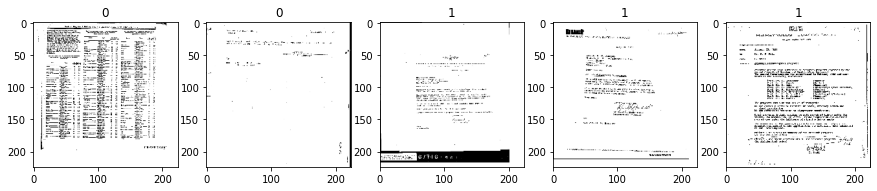

In [170]:
for X_test, y_test in keras_generator(df_resized,batch_size=5):
  break


In [ ]:
show_images(X_test, y_test)

In [171]:
y_test

[0, 0, 1, 1, 1]

In [143]:
y_test.shape

(5,)

In [144]:
X_test.shape

(5, 224, 224, 3)

# Изображение мы разрезали. Теперь нужно наложить маску. 

In [145]:

from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
import matplotlib.patches as patches
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten,Dropout,InputLayer, Input, Activation, GlobalAveragePooling2D, BatchNormalization

In [146]:
WEIGHT_DECAY = 0.001

wd = tf.keras.regularizers.l2(WEIGHT_DECAY)

args = {'padding':'same', 'activation': 'relu','kernel_regularizer':wd}

In [147]:
# inputs = Input(shape=(win_size, win_size,3))

# x = Conv2D(32, (3, 3), **args)(inputs)
# x = BatchNormalization()(x)
# x = Conv2D(32, (3, 3), **args)(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D((2, 2))(x)
# x = Conv2D(64, (3, 3), **args)(x)
# x = BatchNormalization()(x)
# x = Conv2D(64, (3, 3), **args)(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D((2, 2))(x)
# x = Conv2D(128, (3, 3), **args)(x)
# x = BatchNormalization()(x)
# x = Conv2D(128, (3, 3), **args)(x)
# x = BatchNormalization()(x)
# x = Conv2D(128, (3, 3), **args)(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D((2, 2))(x)
# # x = GlobalAveragePooling2D()(x)
# x = Flatten()(x)
# x = Dense(256, activation=tf.nn.relu, kernel_regularizer = wd)(x)
# x = Dropout(0.2)(x)
# x = Dense(256, activation=tf.nn.relu, kernel_regularizer = wd)(x)
# x = Dropout(0.2)(x)
# # x = Dense(5*10, activation=None)(x)
# out = Dense(1, activation='sigmoid', name='score')(x) # Этим выводам нужно присвоить названия.
# # out2 = Dense(4, name='bbx')(x)

# model_classify = Model(inputs=inputs, outputs=out)   
# # model_custom = Model()

In [148]:
WEIGHT_DECAY = 0.001

wd = tf.keras.regularizers.l2(WEIGHT_DECAY)

In [149]:
# конфигурирование слоев нейросети
model_classify = Sequential()

model_classify.add(InputLayer(input_shape = (win_size, win_size, 3)))

model_classify.add(Conv2D(filters=32, kernel_size=3,activation='relu',kernel_regularizer=wd, padding='same'))
model_classify.add(BatchNormalization())
model_classify.add(Conv2D(filters=32, kernel_size=3,activation='relu', kernel_regularizer=wd, padding='same'))
model_classify.add(BatchNormalization())

# model.add(MaxPooling2D(pool_size=(2, 2)))
model_classify.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))

model_classify.add(Conv2D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=wd, padding='same'))
model_classify.add(BatchNormalization())
model_classify.add(Conv2D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=wd, padding='same'))
model_classify.add(BatchNormalization())

model_classify.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))

# полносвязные слои нейронной сети
model_classify.add(Flatten())
model_classify.add(Dense(256,kernel_regularizer=wd, activation=Activation('relu')))
# model.add(BatchNormalization())
model_classify.add(Dropout(0.3))
model_classify.add(Dense(256,kernel_regularizer=wd, activation=Activation('relu')))
# model.add(BatchNormalization())
model_classify.add(Dropout(0.3))
model_classify.add(Dense(1,kernel_regularizer=wd, activation=Activation('sigmoid')))

# model_classify.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

# компиляция модели
model_classify.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [150]:
# model_classify.compile(optimizer='Adam', loss='binary_crossentropy',metrics=['accuracy'])

In [151]:
# model_classify.summary()

In [152]:
# checkpoint_best_IoU = tf.keras.callbacks.ModelCheckpoint('models/model_logo_15_bestIoU.h5',
#                                                   monitor='val_bbx_IoU',
#                                                   mode='max',
#                                                   save_best_only=True,
#                                                   save_weights_only=False,
#                                                   save_freq='epoch',
#                                                   verbose=1
#                                                  )
checkpoint_best_Loss = tf.keras.callbacks.ModelCheckpoint('models/model_cassify_best_loss.h5',
                                                  monitor='val_loss',
                                                  mode='auto',
                                                  save_best_only=True,
                                                  save_weights_only=True,
                                                  save_freq='epoch',
                                                  verbose=1
                                                 )

In [153]:
batch_size_training = 16
batch_size_testing = 8

In [154]:
steps_per_epoch_training = len(train_df_classify)//batch_size_training #1000# len(train_generator)
steps_per_epoch_testing = len(test_df_classify)//batch_size_testing
steps_per_epoch_val = len(val_df_classify)//batch_size_testing
num_epochs = 100

steps_per_epoch_training#, steps_per_epoch_validation, steps_per_epoch_testing

37

In [155]:
train_generator = keras_generator(train_df_classify,batch_size=batch_size_training)
test_generator = keras_generator(test_df_classify,batch_size=batch_size_testing)
val_generator = keras_generator(val_df_classify,batch_size=batch_size_testing)

In [156]:
NUM_EPOCHS = 100

history = model_classify.fit(train_generator,
                       epochs=NUM_EPOCHS,
                       steps_per_epoch = steps_per_epoch_training,
                       validation_data= test_generator,
                       validation_steps= steps_per_epoch_testing, 
                       shuffle=True,
                       callbacks = [checkpoint_best_Loss],
                       verbose=1,
                       )

Epoch 1/100
37/37 [==============================] - 8s 184ms/step - loss: 3.0972 - accuracy: 0.6926 - val_loss: 2.7010 - val_accuracy: 0.4350

Epoch 00001: val_loss improved from inf to 2.70105, saving model to models/model_cassify_best_loss.h5
Epoch 2/100
37/37 [==============================] - 6s 171ms/step - loss: 1.5156 - accuracy: 0.7838 - val_loss: 4.2856 - val_accuracy: 0.5100

Epoch 00002: val_loss did not improve from 2.70105
Epoch 3/100
37/37 [==============================] - 6s 174ms/step - loss: 0.7265 - accuracy: 0.8378 - val_loss: 10.5293 - val_accuracy: 0.4050

Epoch 00003: val_loss did not improve from 2.70105
Epoch 4/100
37/37 [==============================] - 6s 171ms/step - loss: 0.5850 - accuracy: 0.8649 - val_loss: 11.3348 - val_accuracy: 0.3900

Epoch 00004: val_loss did not improve from 2.70105
Epoch 5/100
37/37 [==============================] - 7s 183ms/step - loss: 0.4160 - accuracy: 0.8885 - val_loss: 10.4888 - val_accuracy: 0.4400

Epoch 00005: val_loss 

In [159]:
val_df_classify

,doc_name,type
600,../pages/small_images/aji32e00-page02_2.tif,0
601,../pages/small_images/egg15f00-page2-full_8.tif,0
602,../pages/small_images/dmv70a00_3.tif,0
603,../pages/small_images/icr55d00.tif,1
604,../pages/small_images/mbw13f00-page2_4.tif,0
...,...,...
795,../pages/small_images/bat60e00.tif,1
796,../pages/small_images/hcj11c00-page02_2.tif,0
797,../pages/small_images/crr09c00_1.tif,1
798,../pages/small_images/fzx20e00-page02_2.tif,0


In [205]:
eval = model_classify.evaluate(val_generator,steps=steps_per_epoch_val, verbose=0)
print('Model performance:')
print('loss for test dataset is : {}'.format(eval[0]))
print('accuracy for test dataset is : {}'.format(eval[1]))

Model performance:
loss for test dataset is : 1.1880930662155151
accuracy for test dataset is : 0.7900000214576721


In [ ]:
# model_classify.evaluate(test_df_classify,batch_size=16), steps=(len(train_df_classify)/16)

In [204]:
model_classify.load_weights('models/model_cassify_best_loss.h5')

In [203]:
model_classify.save(f'models/model_cassify_{NUM_EPOCHS}.hdf5')

NotImplementedError: Layer ModuleWrapper has arguments in `__init__` and therefore must override `get_config`.

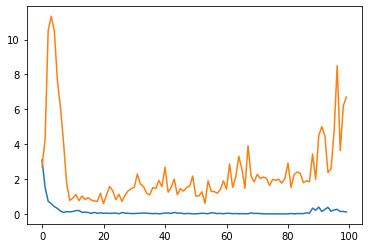

In [163]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

Проверим результаты. 

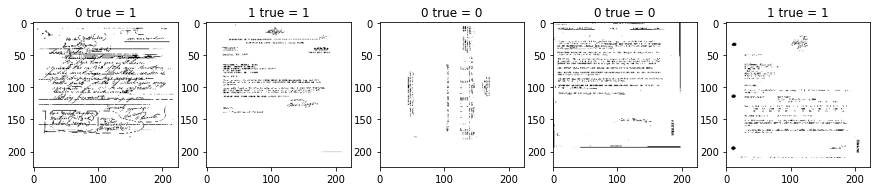

In [211]:
for X_test, y_test in keras_generator(test_df_classify,batch_size=5):
  break

pred = model_classify.predict(X_test)

pred_y = [int(np.round(p[0])) for p in pred]

show_images(X_test, pred_y, y_test)

In [ ]:
# определим реальную позицию прямоугольников и их координаты на изначальном изображении.
# Объединим все bounding box-ы в один.

def combined_bb(win_coords,scores, bbx, threshold=0.9):
    if np.max(scores)< threshold:
        return [0,0,0,0]
        
    top_row,left_col,bottom_row,right_col= IM_SIZE[0],IM_SIZE[1],0,0
    for i, b in enumerate(bbx):
        if (scores[i] >= threshold):
            box = b * win_size
            box[0] += win_coords[i][1]-box[2]/2  
            box[1] += win_coords[i][0]-box[3]/2
            box[2] += box[0]  
            box[3] += box[1]
            # if(box[1]< IM_SIZE[1]/2):
            #     continue
            if(box[1]> IM_SIZE[1]/2):
                continue
            # print(box)
            top_row = box[0] if box[0] < top_row else top_row
            left_col = box[1] if box[1] < left_col else left_col
            bottom_row = box[2] if box[2] > bottom_row else bottom_row
            right_col = box[3] if box[3] > right_col else right_col
            # break
    return [top_row,left_col,bottom_row-top_row,right_col-left_col]

../pages/source_prepare/bfr18e00-page02_1.tif


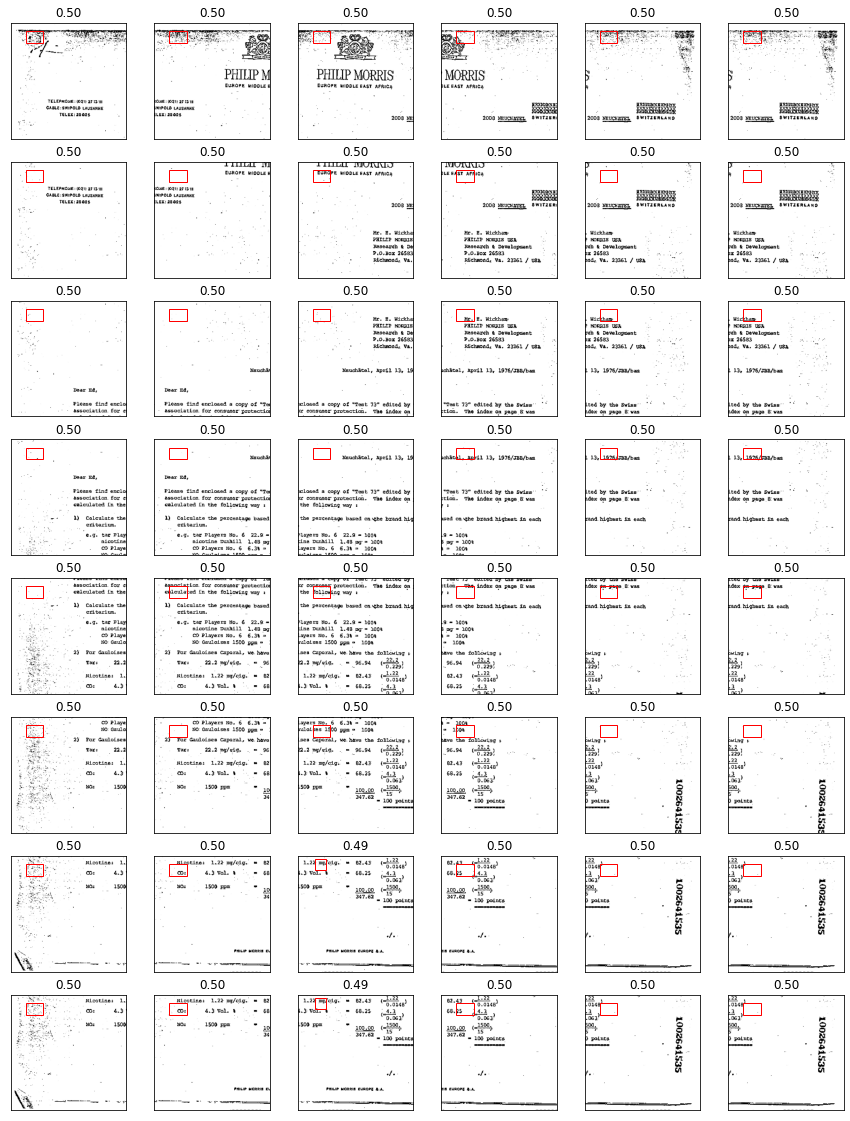

In [ ]:
for X_test, y_test in keras_generator(test_df_classify,batch_size=1,is_test=True):
  break

predict = model_logo.predict(X_test)

show_result(X_test,predict[0][:,0], predict[1])

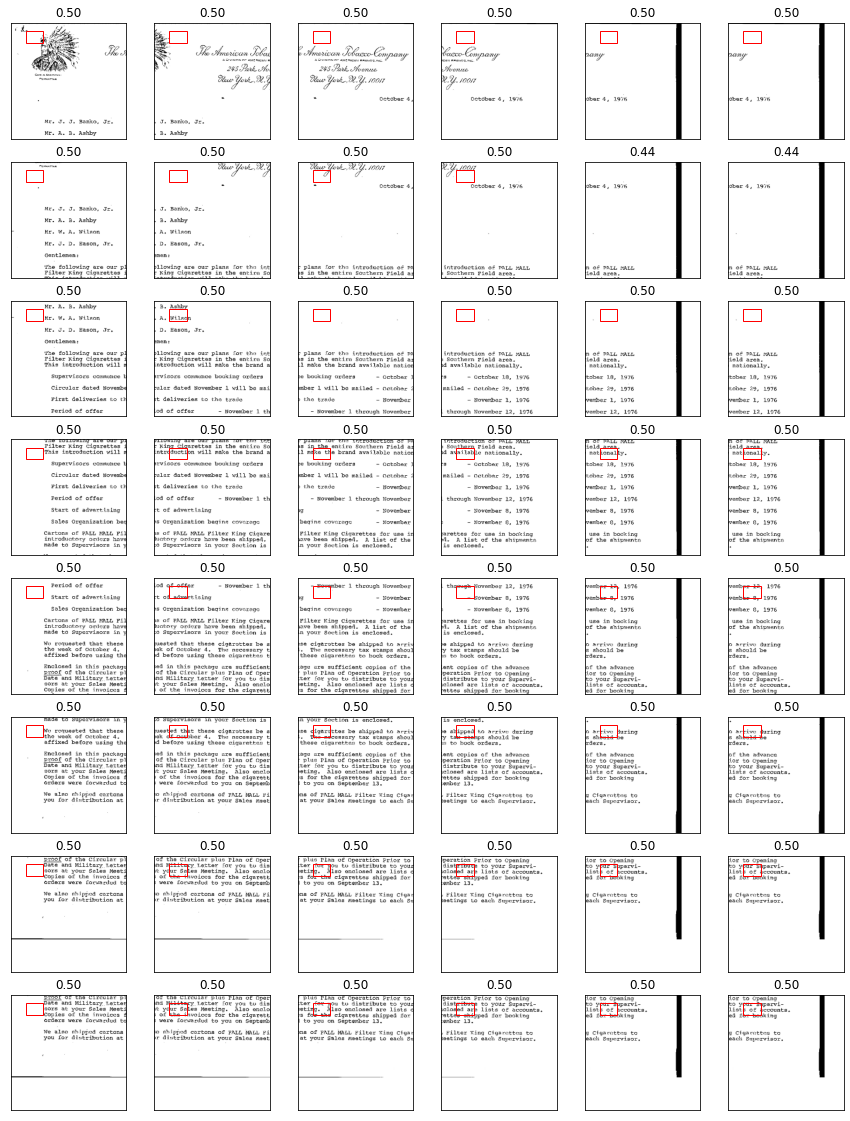

In [ ]:
img = cv2.imread('../pages/source_prepare/ciy01a00-page02_1.tif')
img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_list = split_image(img)
predict = model_logo.predict(img_list)
show_result(img_list,predict[0][:,0],predict[1])

In [ ]:
bb = combined_bb(win_coords, predict[0], predict[1], threshold=0.5)
rect = patches.Rectangle((bb[0], bb[1]), bb[2], bb[3], linewidth=1, edgecolor='r', facecolor='none')

fig,ax = plt.figure(figsize(10,10))
ax.imshow(img, 'gray', vmin=0, vmax=1,)
ax.add_patch(rect)
plt.show()

NameError: name 'figsize' is not defined

In [ ]:
def get_original_size_bb(bb, old_size):
    scale_width = old_size[0]/IM_SIZE[0]
    scale_height = old_size[1]/IM_SIZE[1]
    original_bb = [0,0,0,0]
    original_bb[0] = bb[0]*scale_width
    original_bb[1] = bb[1]*scale_height
    original_bb[2] = bb[2]*scale_width
    original_bb[3] = bb[3]*scale_height
    return original_bb

In [ ]:
old_size = df_logo.loc[(df_logo['doc_name']=='../pages/source_prepare/nuz52d00.tif'),['old_width','old_height']].values[0]

original_bb = get_original_size_bb(bb, old_size)
print(original_bb)
img = cv2.imread('../pages/source/nuz52d00.tif')
img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

rect = patches.Rectangle((original_bb[0], original_bb[1]), original_bb[2], original_bb[3], linewidth=1, edgecolor='r', facecolor='none')

fig,ax = plt.figure(fig_size(10,10))
ax.imshow(img, 'gray', vmin=0, vmax=1,)
ax.add_patch(rect)
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0